# Notebook for creating figures for RO paper

In [1]:
%load_ext autoreload
%autoreload 2

## document python and jupyter versions

In [2]:
!python --version

Python 3.11.2


In [3]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.10.0
ipykernel        : 6.21.2
ipywidgets       : 8.0.4
jupyter_client   : 7.4.7
jupyter_core     : 5.1.0
jupyter_server   : 2.3.0
jupyterlab       : 3.6.3
nbclient         : 0.7.2
nbconvert        : 7.2.9
nbformat         : 5.7.3
notebook         : 6.5.2
qtconsole        : 5.4.0
traitlets        : 5.6.0


---

In [4]:
import yaml
import pandas as pds
import numpy as np
import seaborn as sns
import tarfile
import matplotlib.pyplot as plt
from collections import defaultdict

### create list of obo ontologies from yaml file downloaded from obofoundry.org

In [5]:
with open('obo_ontologies.yml', 'r') as f:
    obo_dict = yaml.safe_load(f)

In [6]:
obo_ids = [o["id"].upper().strip() for o in obo_dict["ontologies"]]
len(obo_ids)

256

In [7]:
obo_ids[:5] # testing

['ADO', 'AGRO', 'AISM', 'AMPHX', 'APO']

### simple function identify an RO relation

In [8]:
def is_ro_predicate(name):
    bfo_relations = [
        "BFO:0000050",
        "BFO:0000051",
        "BFO:0000054",
        "BFO:0000055",
        "BFO:0000060",
        "BFO:0000062",
        "BFO:0000063",
        "BFO:0000066",
        "BFO:0000067" 
    ]
    return (name[0:3] == "RO:") or (name in bfo_relations)
    

### get list of obo statistics files from archive

In [9]:
with tarfile.open('statistics.tgz', 'r:*') as tar:
    obo_filenames = [
         name
         for name in tar.getnames()
        
         # check id is an obo ontology: after the '/' and before the '.'
         # e.g. statistics/ncro.statistics.yaml -> NCRO
         if '/' in name and \
            name.split('/')[1].split('.')[0].upper() in obo_ids
     ]

In [10]:
num_obo_files = len(obo_filenames)
print(f'number statistics files: {num_obo_files}')

number statistics files: 178


In [11]:
obo_filenames[:5] # testing

['statistics/ncro.statistics.yaml',
 'statistics/scdo.statistics.yaml',
 'statistics/stato.statistics.yaml',
 'statistics/spd.statistics.yaml',
 'statistics/hsapdv.statistics.yaml']

### open each obo statistics tar file

In [12]:
dfs = []
with tarfile.open('statistics.tgz', 'r:*') as tar:
    for member in tar.getmembers():
        if member.isfile() and member.name in obo_filenames:
            # get id ontology: after the '/' and before the '.'
            # e.g. statistics/ncro.statistics.yaml -> NCRO
            ns = member.name.split('/')[1].split('.')[0].upper()
            stat_dict =  yaml.safe_load(tar.extractfile(member).read())
            # predicates = stat_dict['partitions'][ns]['edge_count_by_predicate'].keys
            
            try:
                # partition = stat_dict['partitions'][ns]
                # get partition, and make keys all upper case
                # this is to account for cases such as FBcv
                # FBcv will be transformed to FBCV for search purposes
                partitions = {k.upper():v for k, v in stat_dict['partitions'].items()} 
                partition_ns = partitions[ns]
                
                # used for testing
                # if ns == 'FBCV':
                #     print(partition_ns['edge_count_by_predicate'])
                    
            except KeyError as ke:
                print(f'{ns}: no partition key')
                continue

            try:
                predicates = partition_ns['edge_count_by_predicate'].keys()
                ro_predicates = [p for p in predicates if is_ro_predicate(p)]  # filter for RO predicates
                if len(ro_predicates) > 0:
                    data = {'id': [ns]*len(ro_predicates), 'relation': ro_predicates}
                else:
                    data = {'id': [ns]*len(ro_predicates), 'relation': np.nan}
                
                # if ns == 'PR': print(data) # for testing
                dfs.append(pds.DataFrame(data))
            except KeyError as ke:
                print(f'{ns}: no edge_count_by_predicate')
                continue

CHIRO: no partition key
UPHENO: no edge_count_by_predicate
SBO: no partition key
SWO: no partition key
KISAO: no partition key
DPO: no partition key
EPIO: no partition key
CMO: no partition key
FIDEO: no partition key


### build dataframe

In [13]:
df = pds.concat(dfs, ignore_index=True)

peek at dataframe

In [14]:
df.head()

,id,relation
0,NCRO,BFO:0000063
1,NCRO,RO:0000056
2,NCRO,RO:0000057
3,NCRO,RO:0001000
4,SCDO,RO:0003302


testing that mixed case FBcv was processed

In [15]:
df.query("id == 'FBCV'")

,id,relation
508,FBCV,RO:0000087


stats about data processing|

In [16]:
print(f'dataframe length: {len(df)}')

unique_df_ids = df["id"].unique()
num_unique_df_ids = len(unique_df_ids)
print(f'number of files with RO relation: {num_unique_df_ids} (out of a total of {num_obo_files} OBO Foundry ontologies)')
print(f'percent of files with RO relation compared to number of OBO Foundry ontologies: {round(num_unique_df_ids/num_obo_files, 2) * 100}')

dataframe length: 782
number of files with RO relation: 111 (out of a total of 178 OBO Foundry ontologies)
percent of files with RO relation compared to number of OBO Foundry ontologies: 62.0


list of obo foundry ids (from website) that were not in the dataframe ids (extracted from zip files)

In [17]:
for id_ in [id_ for id_ in obo_ids if id_ not in unique_df_ids]:
    print(id_)

ADO
APO
BFO
CDAO
CHEMINF
CHIRO
CIO
CMO
CRO
CTO
DDANAT
DDPHENO
DISDRIV
DPO
DUO
ECO
EMAPA
EPIO
FBBI
FIDEO
FLOPO
FOBI
FOODON
GEO
GNO
HANCESTRO
HOM
HSO
HTN
MA
MCO
MFOEM
MI
MIAPA
MICRO
MMO
MOD
MPATH
MPIO
MS
NCBITAXON
NCIT
NGBO
NOMEN
OGMS
OMO
ONE
ONTOAVIDA
PECO
PLANA
PLANP
PPO
PW
RS
RXNO
SO
SPD
SWO
SYMP
T4FS
TAXRANK
TRANS
TTO
TXPO
UO
UPHENO
VBO
VT
VTO
XLMOD
ZECO
GSSO
HP
KISAO
SBO
FIX
MAMO
REX
SIBO
VARIO
AEO
CEPH
EHDAA2
FMA
GAZ
IDOMAL
MIRO
RNAO
TADS
TGMA
UPA
AAO
ADW
AERO
ATO
BCGO
BILA
BOOTSTREP
CMF
DC_CL
DINTO
EHDA
EHDAA
EMAP
EO
EPO
ERO
EV
FBSP
FLU
GRO
HABRONATTUS
IEV
IMR
IPR
LIPRO
LOGGERHEAD
MAO
MAT
MFO
MIRNAO
MO
NIF_CELL
NIF_DYSFUNCTION
NIF_GROSSANATOMY
NMR
OBO_REL
OGI
OMIABIS
PAO
PD_ST
PGDSO
PLO
PROPREO
RESID
SAO
SEP
SOPHARM
TAHE
TAHH
TAO
VHOG
VSAO
YPO
ZEA


### save dataframe for later use if needed

In [18]:
df.to_csv('obo_ro_usage.tsv', sep='\t', index=False)

### remove RO relations from dataframe and generate stats on RO usage

In [19]:
non_ro_ids = [id_ for id_ in df['id'].values if not is_ro_predicate(id_)]

In [20]:
non_ro_df = df[df['id'].isin(non_ro_ids)].drop_duplicates()

In [21]:
len(non_ro_df)

782

In [22]:
non_ro_df.id.value_counts()

UBERON         73
GO             66
ENVO           60
FBBT           37
CL             32
               ..
COB             1
BSPO            1
PDUMDV          1
ZP              1
WBPHENOTYPE     1
Name: id, Length: 111, dtype: int64

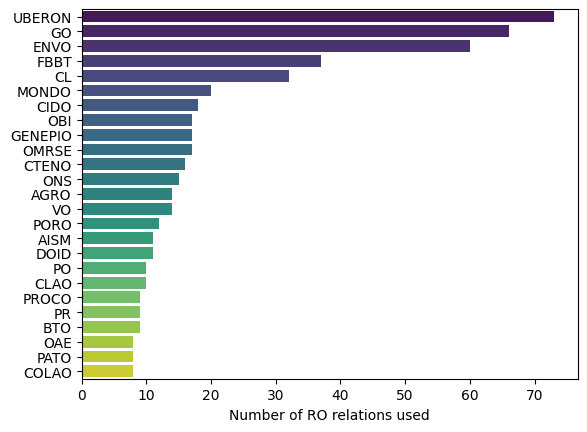

<Figure size 640x480 with 0 Axes>

In [23]:
plot_df = pds.DataFrame(non_ro_df.id.value_counts().head(25).reset_index())
ax = sns.barplot(y='index', x='id', data=plot_df, palette='viridis') #color='steelblue')
ax.set(xlabel='Number of RO relations used', ylabel=None)
plt.show()
plt.savefig('obo_ro_usage.png', dpi=600)

---

### keeping old code for querying ontobee around for posterity

In [24]:
import pandas as pds
from SPARQLWrapper import SPARQLWrapper, JSON
from SPARQLWrapper.sparql_dataframe import get_sparql_dataframe

set Ontobee endpoint and return format

In [25]:
endpoint = "http://sparql.hegroup.org/sparql/"

In [26]:
sparql = SPARQLWrapper(endpoint)
sparql.setReturnFormat(JSON)

In [27]:
def make_query(namespace):
    q = """
    prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    prefix owl: <http://www.w3.org/2002/07/owl#>
    prefix merged: <http://purl.obolibrary.org/obo/merged/>
    
    select distinct ?namespace ?relation ?label where 
    {
      # set of BFO relations in RO
      values ?bfo_ro 
      {
        "obo:BFO_0000050" 
        "obo:BFO_0000051" 
        "obo:BFO_0000054" 
        "obo:BFO_0000055" 
        "obo:BFO_0000060" 
        "obo:BFO_0000062" 
        "obo:BFO_0000063" 
        "obo:BFO_0000066" 
        "obo:BFO_0000067" 
      }

      graph merged:%s 
      {
        # define types
        ?s a owl:Class .
        ?o a owl:Class .
        ?r a owl:ObjectProperty .
        
        # find restrictions on class
        ?s (rdfs:subClassOf | owl:equivalentClass)* ?b .
        ?b owl:onProperty+ ?r ;
          (owl:someValuesFrom|owl:allValuesFrom) ?o .
        ?r rdfs:label ?lbl .
      }
      # bind variables as strings using curies for display and ease of use
      bind(replace(str(?r), "http://purl.obolibrary.org/obo/", "obo:") as ?relation)
      bind(replace(str(?s), "http://purl.obolibrary.org/obo/", "obo:") as ?class)
      bind(str(?lbl) as ?label) # removes lang tag and datatype from lable
      bind("%s" as ?namespace)  # display namespace being uses

      
      # filter classes in namespace and RO or BFO/RO relations
      filter(strstarts(?class, "obo:%s_"))
      filter (strstarts(?relation, "obo:RO_") || ?relation in (?bfo_ro))
    }
    """ % (namespace, namespace, namespace)
    return q

In [28]:
# print(make_query("OHD")) # testing

### uncomment cell below get data (it takes a bit of time to execute)

In [29]:
# dfs = []
# for obo_id in obo_ids:
#     try:
#         q = make_query(obo_id)
#         dfs.append(get_sparql_dataframe(endpoint, q))
#     except Exception as e:
#         print(f'{obo_id} error:', e)